# Rain prediction task

This data was taken from the Kaggle dataset linked below. It consists of 10 years of daily weather observations from many locations across Australia.

The objective is to predict next-day rain by training classification models on the target variable RainTomorrow.

https://www.kaggle.com/jsphyg/weather-dataset-rattle-package

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

In [2]:
weatherdata = pd.read_csv('weatherAUS.csv')
weatherdata.head()

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
1  2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
2  2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
3  2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
4  2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   

  WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  Humidity3pm  \
0           W           44.0          W  ...        71.0         22.0   
1         WNW           44.0        NNW  ...        44.0         25.0   
2         WSW           46.0          W  ...        38.0         30.0   
3          NE           24.0         SE  ...        45.0         16.0   
4           W           41.0        ENE  ...        82.0         33.0   

   Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  \
0       1007.7       1007.1       8.0       NaN     16.9     21.8         No   
1       1010.6       1007.8       NaN       NaN     17.2     24.3         No   
2       1007.6       1008.7       NaN       2.0     21.0     23.2         No   
3       1017.6       1012.8       NaN       NaN     18.1     26.5         No   
4       1010.8       1006.0       7.0       8.0     17.8     29.7         No   

   RainTomorrow  
0            No  
1            No  
2            No  
3            No  
4            No  

[5 rows x 23 columns]

# Initial data checks

#### Data size

In [3]:
weatherdata.shape

(145460, 23)

#### Data types

In [7]:
weatherdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

#### Drop duplicate values

Duplicate records with identical values will not give us any additional information, so we will discard these

In [5]:
initial_no=weatherdata.shape[0]
print("Number of records: ",initial_no)
weatherdata.drop_duplicates(inplace=True)
print(initial_no-weatherdata.shape[0],"records with identical data removed")
print("Number of records after removing duplicates: ",weatherdata.shape[0])

Number of records:  145460
0 records with identical data removed
Number of records after removing duplicates:  145460


#### Check for missing data

In [6]:
weatherdata.isnull().sum()/len(weatherdata)

Date             0.000000
Location         0.000000
MinTemp          0.010209
MaxTemp          0.008669
Rainfall         0.022419
Evaporation      0.431665
Sunshine         0.480098
WindGustDir      0.070989
WindGustSpeed    0.070555
WindDir9am       0.072639
WindDir3pm       0.029066
WindSpeed9am     0.012148
WindSpeed3pm     0.021050
Humidity9am      0.018246
Humidity3pm      0.030984
Pressure9am      0.103568
Pressure3pm      0.103314
Cloud9am         0.384216
Cloud3pm         0.408071
Temp9am          0.012148
Temp3pm          0.024811
RainToday        0.022419
RainTomorrow     0.022460
dtype: float64

There is a lot of missing data in the our dataset - most columns have at least a few % of records with missing values. 

- Around 2% of cases have missing data for the target variable (RainTomorrow) - we will get rid of these cases.
- Many other columns have missing data, which we will impute values for later on.

In [4]:
weatherdata.dropna(subset=['RainTomorrow'], inplace=True)

In [5]:
weatherdata.shape

(142193, 23)

#### Class balance

Text(0.5, 1.0, 'Rained on next day - yes/no')

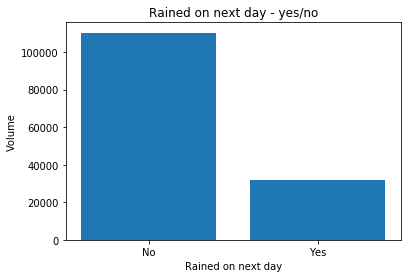

In [14]:
plt.bar(weatherdata['RainTomorrow'].unique(),weatherdata['RainTomorrow'].value_counts().values,width=0.8)
plt.xlabel('Rained on next day')
plt.ylabel('Volume')
plt.title('Rained on next day - yes/no')

The dataset is imbalanced - records where it didn't rain on the next day make up a significantly higher proportion of the dataset (around 78%). This may not be enough to need resampling, but we should be aware of this when considering the performance of the model. For example a high accuracy may be misleading as we need to consider that the null accuracy (the accuracy that could be achieved by always predicting the most frequent class) is already quite high.

We'll also convert the Yes/No label to a binary flag (Yes=1,No=0)

In [6]:
weatherdata['RainTomorrow'].replace({'No': 0, 'Yes': 1},inplace = True)
weatherdata['RainTomorrow'].value_counts()

0    110316
1     31877
Name: RainTomorrow, dtype: int64

#### Check categorical data

In [85]:
weatherdata.select_dtypes(include=['object']).columns

Index(['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm',
       'RainToday'],
      dtype='object')

Convert Date to date time variable.

In [7]:
weatherdata['Date'] = pd.to_datetime(weatherdata['Date'])

Similarly to RainTomorrow, we'll convert RainToday to a binary flag.

In [8]:
weatherdata['RainToday'].value_counts()

No     109332
Yes     31455
Name: RainToday, dtype: int64

In [9]:
weatherdata['RainToday'].replace({'No': 0, 'Yes': 1},inplace = True)
weatherdata['RainToday'].value_counts()

0.0    109332
1.0     31455
Name: RainToday, dtype: int64

In [10]:
weatherdata.select_dtypes(include=['object']).columns

Index(['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'], dtype='object')

In [201]:
print(weatherdata['Location'].nunique())
weatherdata['Location'].value_counts()

49


Canberra            3418
Sydney              3337
Perth               3193
Darwin              3192
Hobart              3188
Brisbane            3161
Adelaide            3090
Bendigo             3034
Townsville          3033
AliceSprings        3031
MountGambier        3030
Launceston          3028
Ballarat            3028
Albany              3016
Albury              3011
PerthAirport        3009
MelbourneAirport    3009
Mildura             3007
SydneyAirport       3005
Nuriootpa           3002
Sale                3000
Watsonia            2999
Tuggeranong         2998
Portland            2996
Woomera             2990
Cobar               2988
Cairns              2988
Wollongong          2983
GoldCoast           2980
WaggaWagga          2976
NorfolkIsland       2964
Penrith             2964
SalmonGums          2955
Newcastle           2955
CoffsHarbour        2953
Witchcliffe         2952
Richmond            2951
Dartmoor            2943
NorahHead           2929
BadgerysCreek       2928


In [22]:
weatherdata['WindGustDir'].value_counts()

W      9780
SE     9309
E      9071
N      9033
SSE    8993
S      8949
WSW    8901
SW     8797
SSW    8610
WNW    8066
NW     8003
ENE    7992
ESE    7305
NE     7060
NNW    6561
NNE    6433
Name: WindGustDir, dtype: int64

In [23]:
weatherdata['WindDir9am'].value_counts()

N      11393
SE      9162
E       9024
SSE     8966
NW      8552
S       8493
W       8260
SW      8237
NNE     7948
NNW     7840
ENE     7735
ESE     7558
NE      7527
SSW     7448
WNW     7194
WSW     6843
Name: WindDir9am, dtype: int64

In [24]:
weatherdata['WindDir3pm'].value_counts()

SE     10663
W       9911
S       9598
WSW     9329
SW      9182
SSE     9142
N       8667
WNW     8656
NW      8468
ESE     8382
E       8342
NE      8164
SSW     8010
NNW     7733
ENE     7724
NNE     6444
Name: WindDir3pm, dtype: int64

The values of location are 49 locations in Australia, and the wind direction variables are the 16 cardinal,intercardinal and secondary intercardinal directions on a compass. These are all legitimate & expected values for the columns.

#### Check numeric data

In [67]:
numeric = [var for var in weatherdata.columns if weatherdata[var].dtype!='O']
weatherdata[numeric].describe()

MinTemp        MaxTemp       Rainfall   Evaporation  \
count  141556.000000  141871.000000  140787.000000  81350.000000   
mean       12.186400      23.226784       2.349974      5.469824   
std         6.403283       7.117618       8.465173      4.188537   
min        -8.500000      -4.800000       0.000000      0.000000   
25%         7.600000      17.900000       0.000000      2.600000   
50%        12.000000      22.600000       0.000000      4.800000   
75%        16.800000      28.200000       0.800000      7.400000   
max        33.900000      48.100000     371.000000    145.000000   

           Sunshine  WindGustSpeed   WindSpeed9am   WindSpeed3pm  \
count  74377.000000  132923.000000  140845.000000  139563.000000   
mean       7.624853      39.984292      14.001988      18.637576   
std        3.781525      13.588801       8.893337       8.803345   
min        0.000000       6.000000       0.000000       0.000000   
25%        4.900000      31.000000       7.000000      13.000000   
50%        8.500000      39.000000      13.000000      19.000000   
75%       10.600000      48.000000      19.000000      24.000000   
max       14.500000     135.000000     130.000000      87.000000   

         Humidity9am    Humidity3pm    Pressure9am    Pressure3pm  \
count  140419.000000  138583.000000  128179.000000  128212.000000   
mean       68.843810      51.482606    1017.653758    1015.258204   
std        19.051293      20.797772       7.105476       7.036677   
min         0.000000       0.000000     980.500000     977.100000   
25%        57.000000      37.000000    1012.900000    1010.400000   
50%        70.000000      52.000000    1017.600000    1015.200000   
75%        83.000000      66.000000    1022.400000    1020.000000   
max       100.000000     100.000000    1041.000000    1039.600000   

           Cloud9am      Cloud3pm        Temp9am        Temp3pm  \
count  88536.000000  85099.000000  141289.000000  139467.000000   
mean       4.437189      4.503167      16.987509      21.687235   
std        2.887016      2.720633       6.492838       6.937594   
min        0.000000      0.000000      -7.200000      -5.400000   
25%        1.000000      2.000000      12.300000      16.600000   
50%        5.000000      5.000000      16.700000      21.100000   
75%        7.000000      7.000000      21.600000      26.400000   
max        9.000000      9.000000      40.200000      46.700000   

           RainToday   RainTomorrow          Month  
count  140787.000000  142193.000000  142193.000000  
mean        0.223423       0.224181       6.402544  
std         0.416541       0.417043       3.426506  
min         0.000000       0.000000       1.000000  
25%         0.000000       0.000000       3.000000  
50%         0.000000       0.000000       6.000000  
75%         0.000000       0.000000       9.000000  
max         1.000000       1.000000      12.000000

At first glance the numeric fields appear to have a distribution of values we'd expect - all the columns only contain  values greater than 0 (apart from those relating to temperature where this is expected).

We can see that rainfall and evaporation have some extreme maximum values which lie far outside the normal range of values (based on the 25-75% percentiles). This appears to be skewing rainfall in particular, which we will deal with later on.

# Exploratory data analysis

#### Categorical variables

No handles with labels found to put in legend.


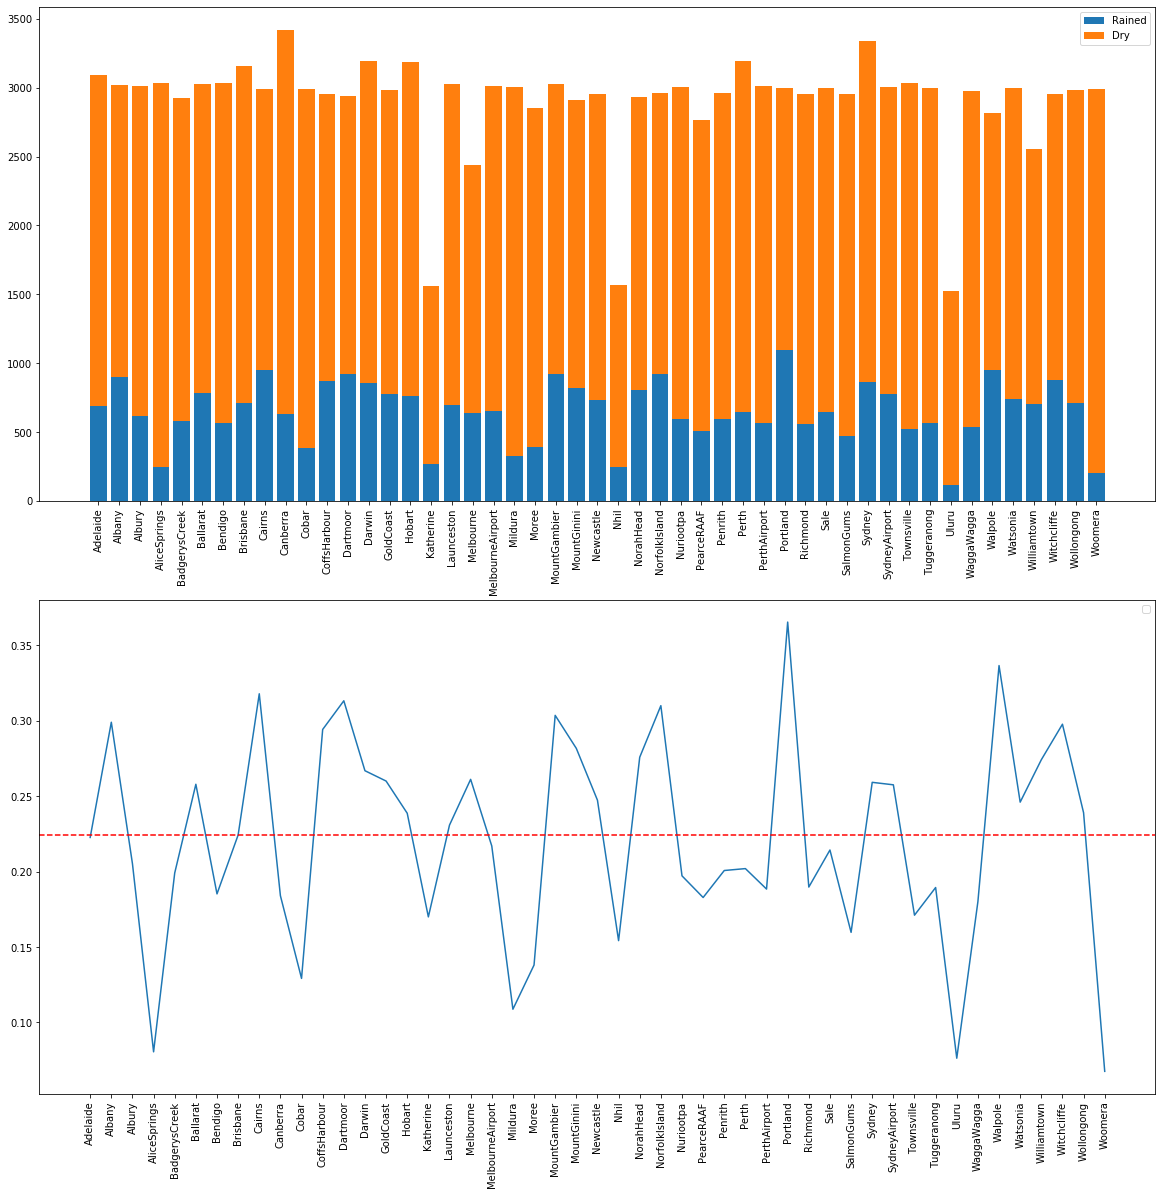

In [204]:
locations=weatherdata.groupby(['Location', 'RainTomorrow']).size().unstack()
locations['Rained']=locations[1]/(locations[0]+locations[1])

plt.figure(figsize=(20, 20))

plt.subplot(211)
plt.bar(locations.index,locations[1],width=0.8,label="Rained")
plt.bar(locations.index,locations[0],width=0.8,bottom=locations[1],label="Dry")
plt.xticks(rotation=90)
plt.legend()

plt.subplot(212)
plt.plot(locations.index,locations['Rained'])
plt.axhline(y=weatherdata['RainTomorrow'].mean(), color='r', linestyle='--')
plt.xticks(rotation=90)
plt.legend()


Certain locations such as Alice Springs, Cobar and Uluru have a much lower probability of rain than the overall average, whilst locations like Walpole and Portland are notably higher.

No handles with labels found to put in legend.


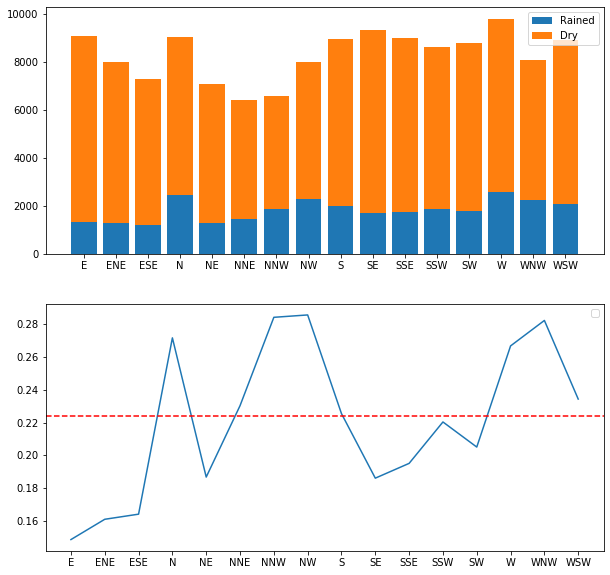

In [205]:
gust=weatherdata.groupby(['WindGustDir', 'RainTomorrow']).size().unstack()
gust['Rained']=gust[1]/(gust[0]+gust[1])

plt.figure(figsize=(10, 10))

plt.subplot(211)
plt.bar(gust.index,gust[1],width=0.8,label="Rained")
plt.bar(gust.index,gust[0],width=0.8,bottom=gust[1],label="Dry")
plt.legend()

plt.subplot(212)
plt.plot(gust.index,gust['Rained'])
plt.axhline(y=weatherdata['RainTomorrow'].mean(), color='r', linestyle='--')
plt.legend()

It seems when the wind direction is from west/northern directions there is a significantly higher probability of rain.

No handles with labels found to put in legend.


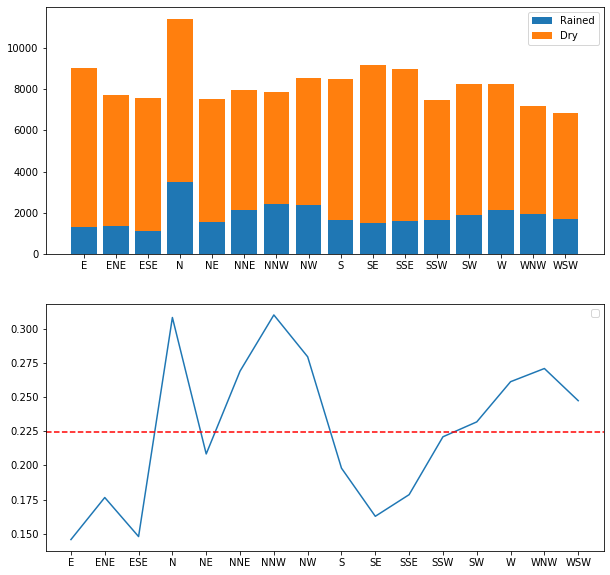

In [206]:
wind9am=weatherdata.groupby(['WindDir9am', 'RainTomorrow']).size().unstack()
wind9am['Rained']=wind9am[1]/(wind9am[0]+wind9am[1])

plt.figure(figsize=(10, 10))

plt.subplot(211)
plt.bar(wind9am.index,wind9am[1],width=0.8,label="Rained")
plt.bar(wind9am.index,wind9am[0],width=0.8,bottom=wind9am[1],label="Dry")
plt.legend()

plt.subplot(212)
plt.plot(wind9am.index,wind9am['Rained'])
plt.axhline(y=weatherdata['RainTomorrow'].mean(), color='r', linestyle='--')
plt.legend()

No handles with labels found to put in legend.


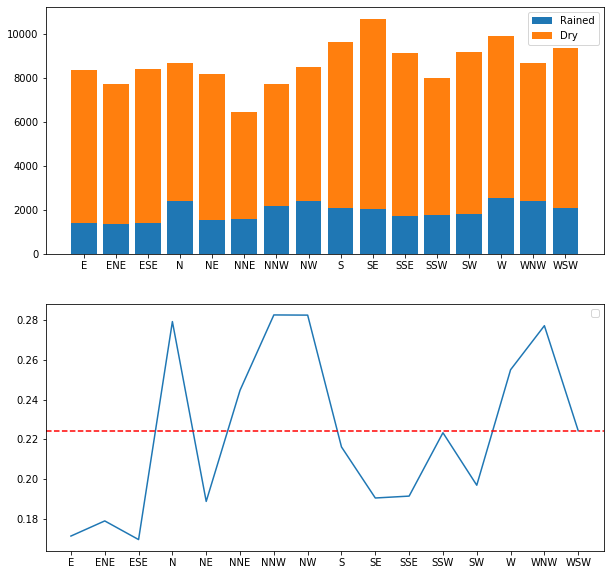

In [207]:
wind3pm=weatherdata.groupby(['WindDir3pm', 'RainTomorrow']).size().unstack()
wind3pm['Rained']=wind3pm[1]/(wind3pm[0]+wind3pm[1])

plt.figure(figsize=(10, 10))

plt.subplot(211)
plt.bar(wind3pm.index,wind3pm[1],width=0.8,label="Rained")
plt.bar(wind3pm.index,wind3pm[0],width=0.8,bottom=wind3pm[1],label="Dry")
plt.legend()

plt.subplot(212)
plt.plot(wind3pm.index,wind3pm['Rained'])
plt.axhline(y=weatherdata['RainTomorrow'].mean(), color='r', linestyle='--')
plt.legend()

#### Wind direction by location

In [233]:
LocationWind=weatherdata.groupby(['Location','WindDir3pm']).size()
LocationWind=LocationWind.unstack(level=-1)
LocationWind=LocationWind.reindex(columns=['W','WNW','NW','NNW','N','NNE','NE','ENE','E','ESE','SE','SSE','S','SSW','SW','WSW'])

directions=[col for col in LocationWind]
LocationWind[directions]=LocationWind[directions].div(LocationWind[directions].sum(axis=1), axis=0)


RainLocationWind=weatherdata.groupby(['Location','WindDir3pm']).mean()[['RainTomorrow']].reset_index()
RainLocationWind=RainLocationWind.pivot(index='Location',columns='WindDir3pm',values='RainTomorrow')
RainLocationWind=RainLocationWind.reindex(columns=['W','WNW','NW','NNW','N','NNE','NE','ENE','E','ESE','SE','SSE','S','SSW','SW','WSW'])

Text(0.5, 1, 'Wind direction frequency by location')

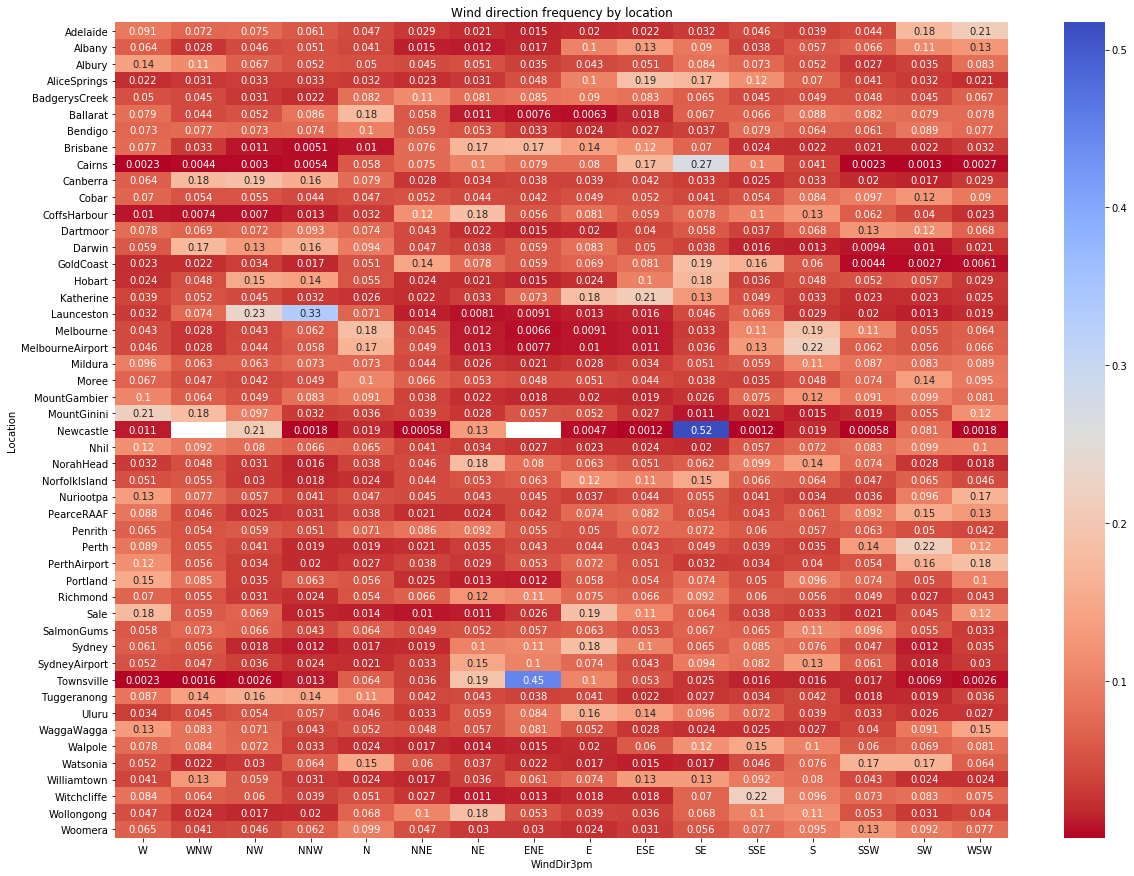

In [234]:
plt.figure(figsize=(20, 15))
sns.heatmap(LocationWind, cmap='coolwarm_r', annot=True, annot_kws={'size':10}, fmt='.2g')
plt.title('Wind direction frequency by location')

Text(0.5, 1, '% of records where RainTomorrow=1')

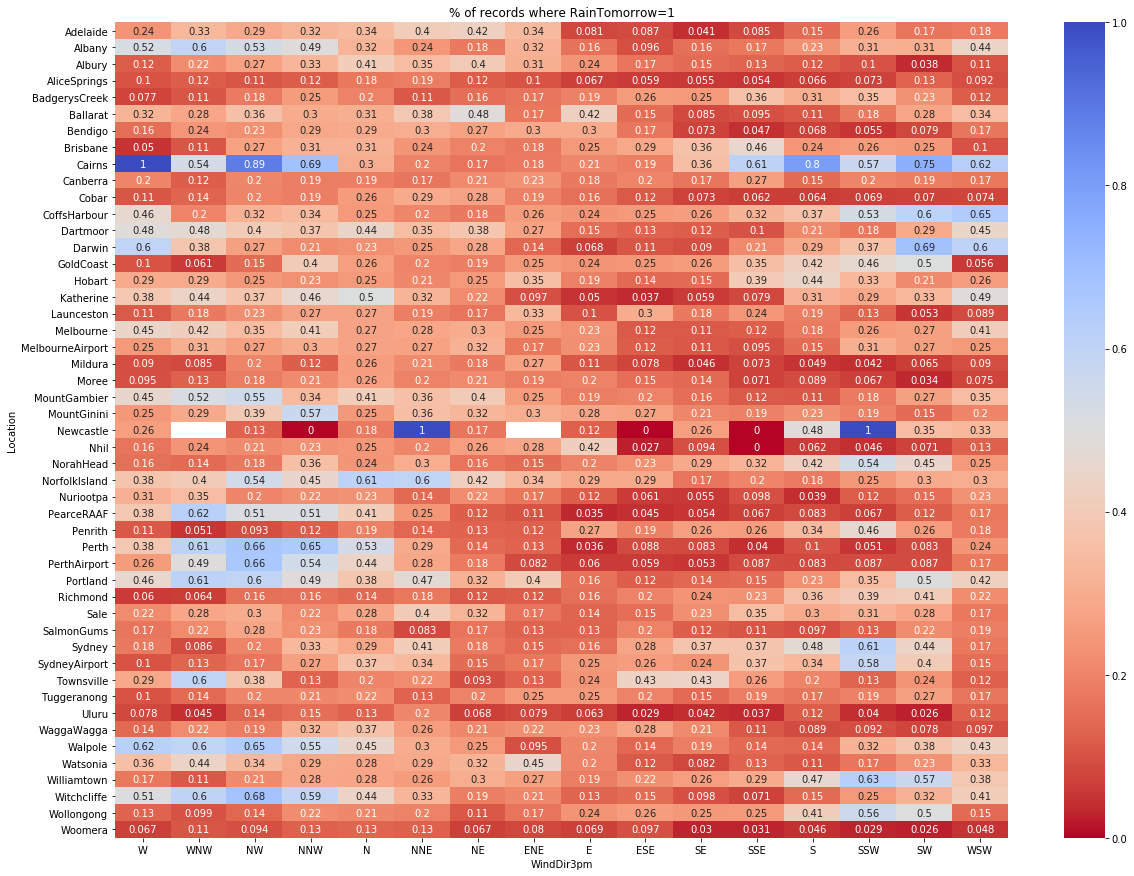

In [235]:
plt.figure(figsize=(20, 15))
sns.heatmap(RainLocationWind, cmap='coolwarm_r', annot=True, annot_kws={'size':10})
plt.title('% of records where RainTomorrow=1')

It does seem like in many locations days where the wind direction is from a western/northern direction have a higher probability of rain, however we also see this doesn't apply for all locations.

#### Date time variable

We'll extract the calendar month from the date column and look at the frequency of rain by month.

No handles with labels found to put in legend.


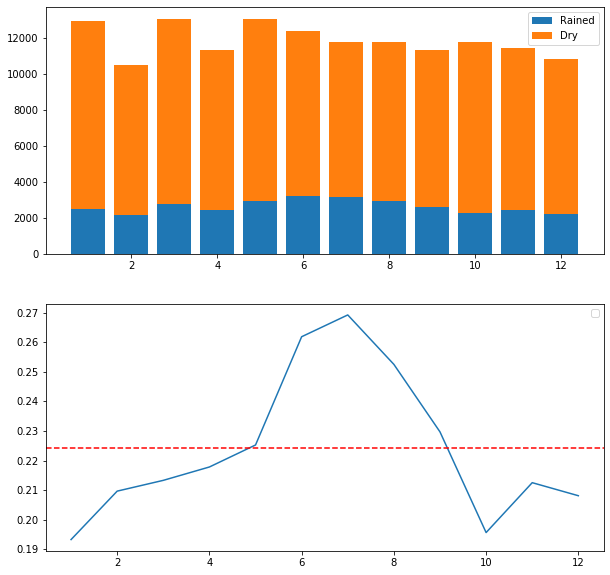

In [208]:
weatherdata['Month']=weatherdata['Date'].dt.month

month=weatherdata.groupby(['Month', 'RainTomorrow']).size().unstack()
month['Rained']=month[1]/(month[0]+month[1])

plt.figure(figsize=(10, 10))

plt.subplot(211)
plt.bar(month.index,month[1],width=0.8,label="Rained")
plt.bar(month.index,month[0],width=0.8,bottom=month[1],label="Dry")
plt.legend()

plt.subplot(212)
plt.plot(month.index,month['Rained'])
plt.axhline(y=weatherdata['RainTomorrow'].mean(), color='r', linestyle='--')
plt.legend()

As we'd expect, the frequency of rain is higher in the Australian winter period.

#### Numeric variables

Plot the distribution of all the numeric variables (split by RainTomorrow)

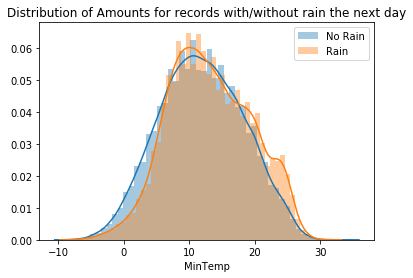

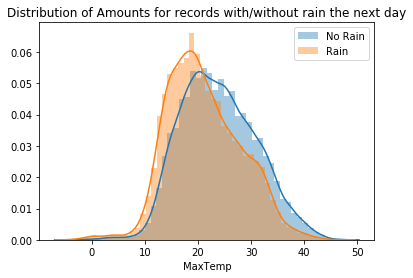

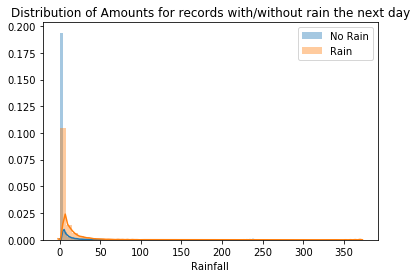

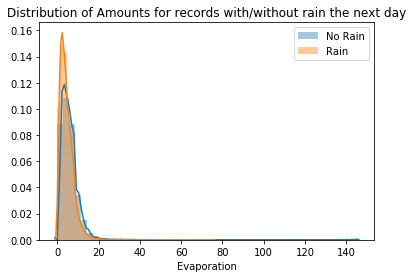

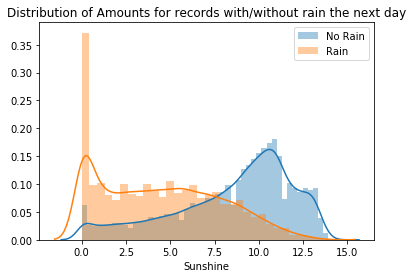

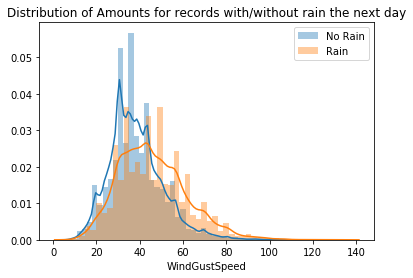

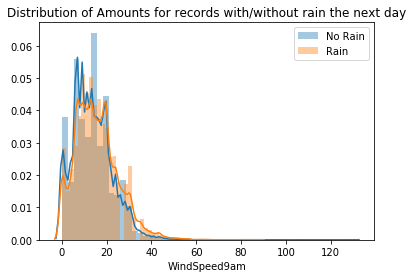

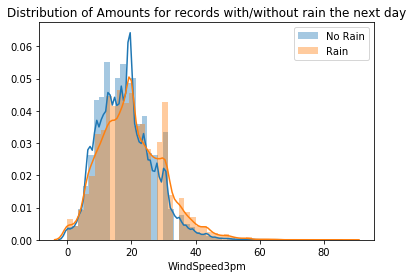

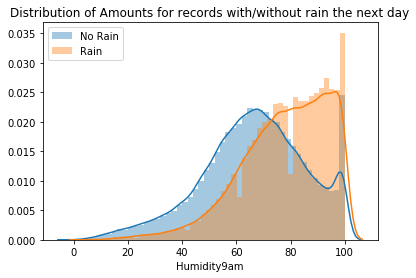

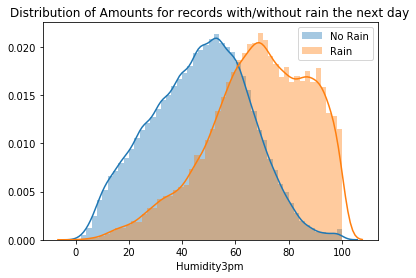

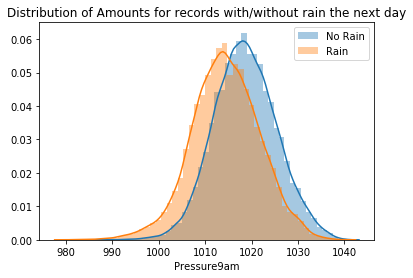

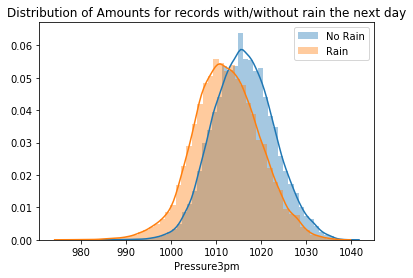

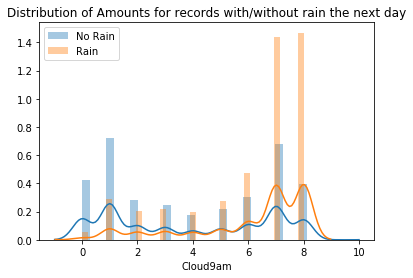

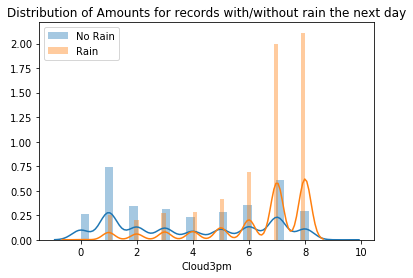

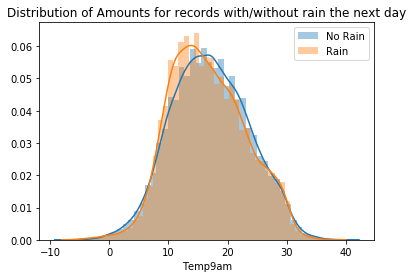

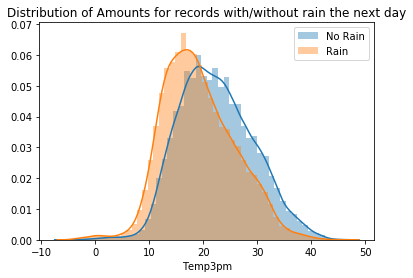

In [94]:
unwantedcols=['RainTomorrow','Date','Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm','Month','RainToday']

for column in weatherdata.drop(unwantedcols,axis=1).columns.tolist():
    plt.figure()
    sns.distplot(weatherdata[weatherdata['RainTomorrow']==0][column])
    sns.distplot(weatherdata[weatherdata['RainTomorrow']==1][column])
    plt.legend(["No Rain", "Rain"])
    plt.title('Distribution of Amounts for records with/without rain the next day')


We can see that a number of features have a visually different distribution where RainTomorrow=1:
- Temperature (especially max & at 3pm) for rainy days appears to be centred around a lower mean average.
- Sunshine has a significantly different different distribution for rainy days - whereas the distribution for dry days is  centred around higher values (10-12), this is not the case for rainy days which have a flatter distribution concentrated more in the lower range. There is also a much higher frequency of records where Sunshine=0.
- The average air pressure for rainy days appears to be centred around a lower mean average.
- The distribution of humidity is significantly shifted to the right for rainy days and has a much higher mean average.

Examine skewness - as we saw earlier the Rainfall column in particular has a high degree of skewness which we will fix with a log transform.

In [133]:
skewness=[]

for column in weatherdata.drop(unwantedcols,axis=1).columns.tolist():
    skewness.append(weatherdata[column].skew())

columnskewness=pd.DataFrame({"Column" : weatherdata.drop(unwantedcols,axis=1).columns.tolist(),"Skewness":skewness})
display(columnskewness.sort_values('Skewness',ascending=False))


Column  Skewness
2        Rainfall  9.888061
3     Evaporation  3.746834
5   WindGustSpeed  0.874305
6    WindSpeed9am  0.775494
7    WindSpeed3pm  0.631433
15        Temp3pm  0.240054
1         MaxTemp  0.224917
14        Temp9am  0.091387
9     Humidity3pm  0.034515
0         MinTemp  0.023900
11    Pressure3pm -0.046198
10    Pressure9am -0.096211
13       Cloud3pm -0.224092
12       Cloud9am -0.224286
8     Humidity9am -0.482821
4        Sunshine -0.502911

In [12]:
import math 

test=[1,2]
test[1] = np.NaN

def LogScale(x):
    if math.isnan(x)==False:
        return np.log(x+1)
    else:
        return x
    
display(test)
display(LogScale(test[0]))
display(LogScale(test[1]))

[1, nan]

0.6931471805599453

nan

Log transformed Rainfall skewness:  2.0473940607872443


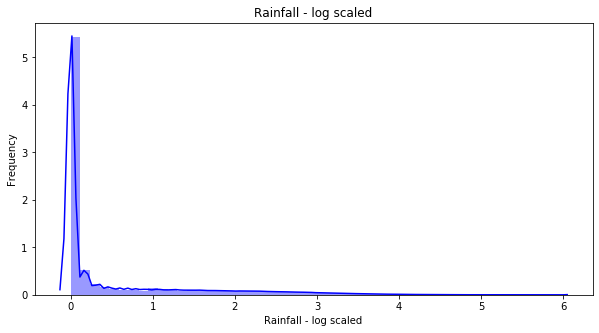

In [13]:
weatherdata['RainfallLogScale'] = weatherdata["Rainfall"].apply(lambda x: LogScale(x))
weatherdata.head()

plt.figure(figsize=(10, 5))

sns.distplot(weatherdata['RainfallLogScale'],color='b')
plt.xlabel('Rainfall - log scaled')
plt.ylabel('Frequency')
plt.title('Rainfall - log scaled')

print("Log transformed Rainfall skewness: ",weatherdata['RainfallLogScale'].skew())

The skewness has been significantly reduced by the log-transform to an acceptable level.

Plotting the relationships between the numeric variables

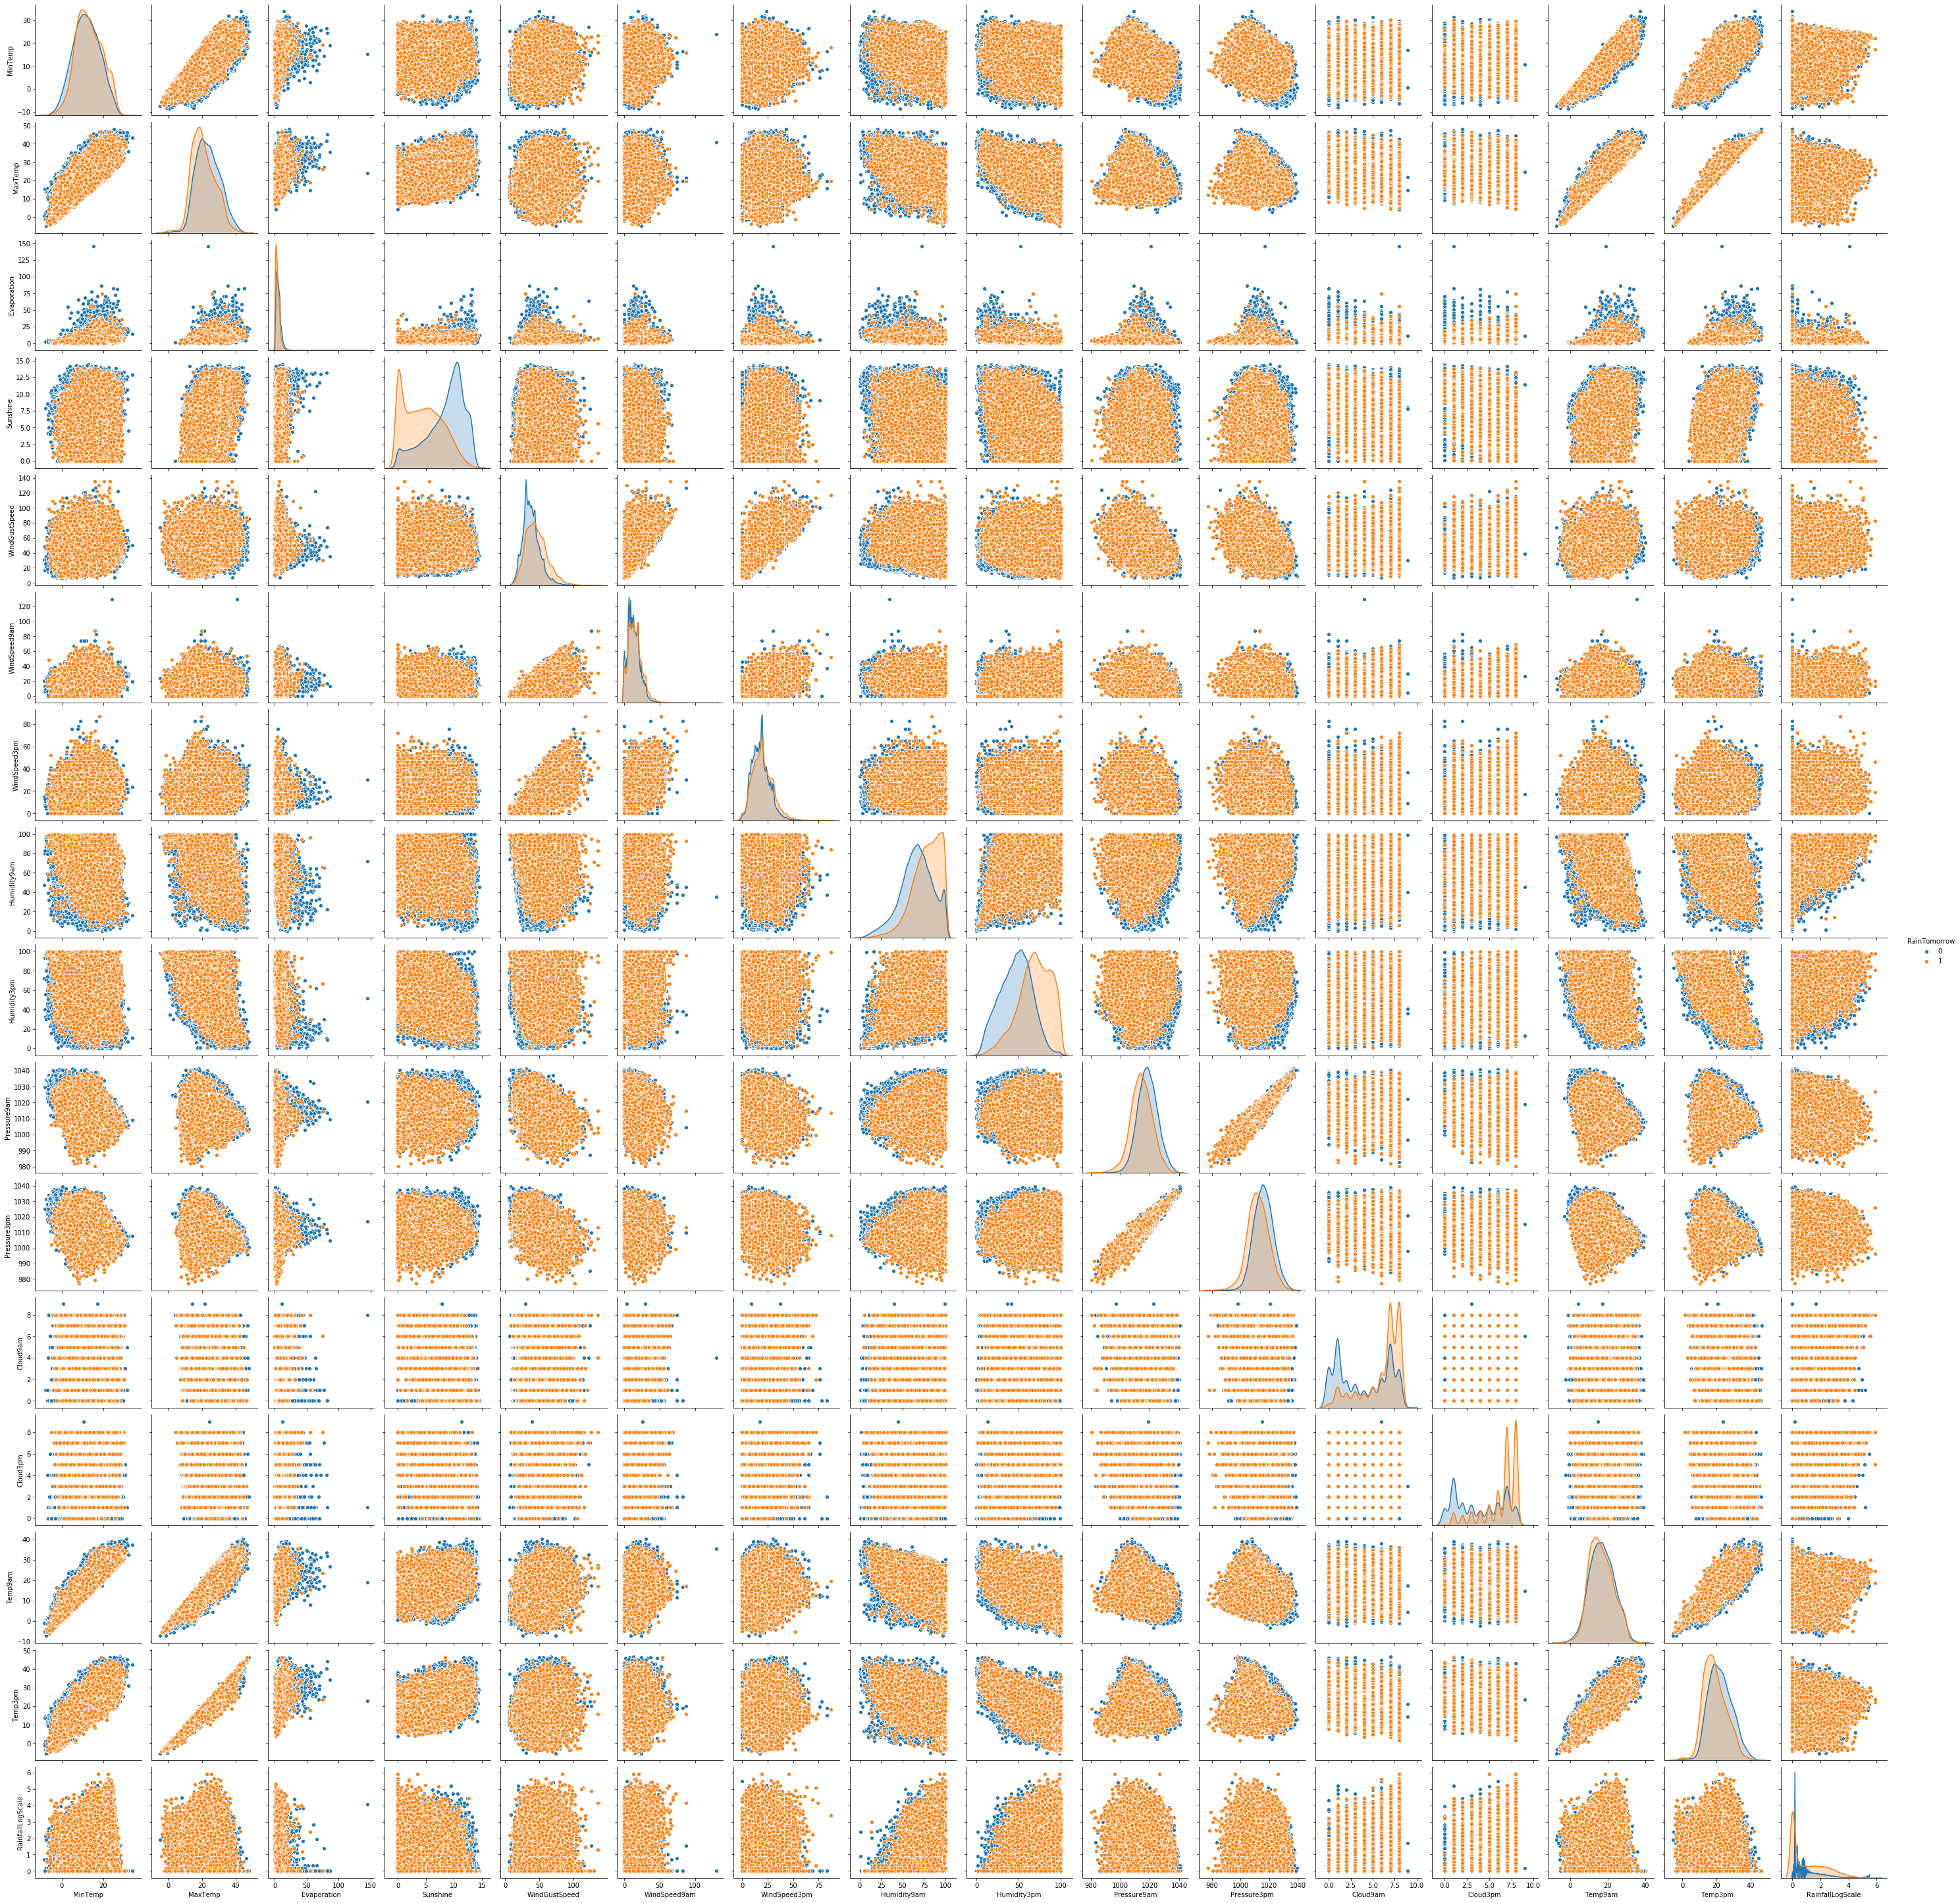

In [163]:
unwantedcols=['Date','Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm','Month','RainToday','Rainfall']

sns.pairplot(weatherdata.drop(unwantedcols,axis=1),hue='RainTomorrow')

#### Variable correlations

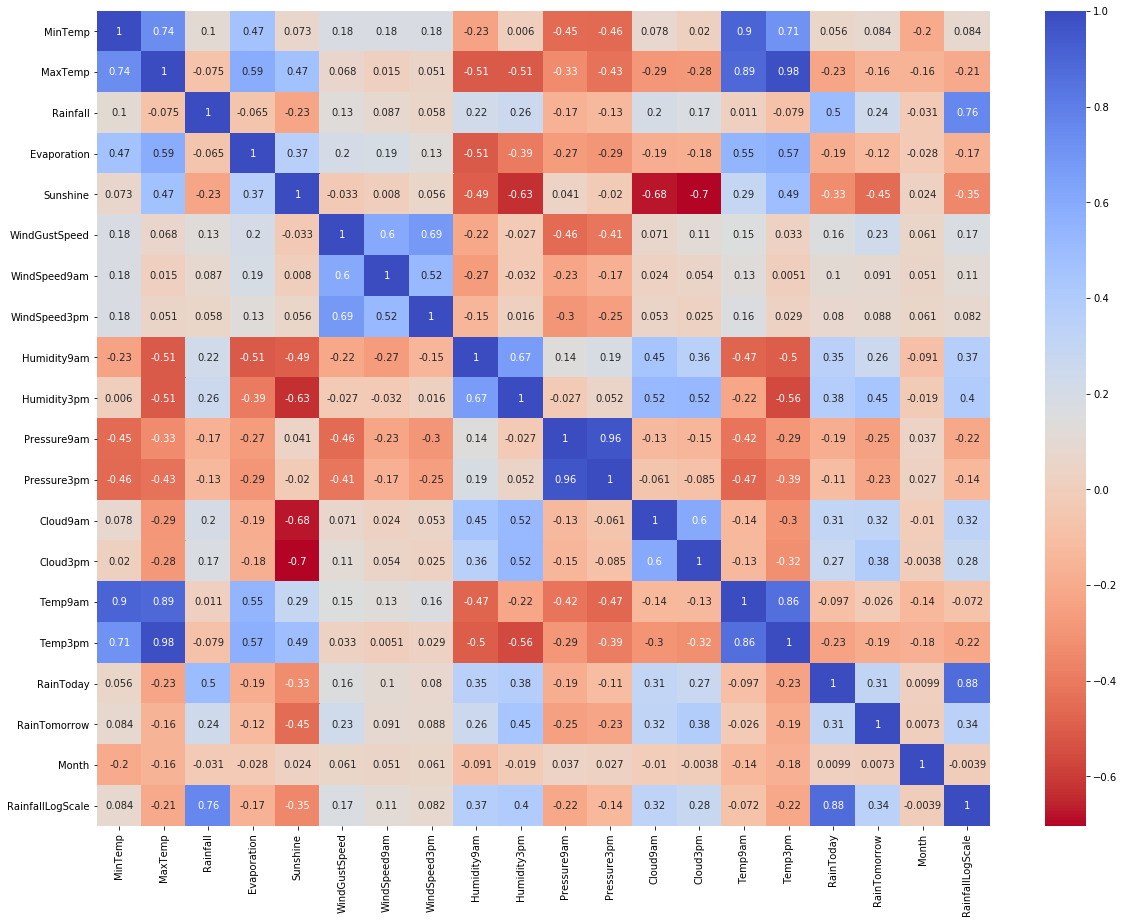

In [167]:
corr = weatherdata.corr()

plt.figure(figsize=(20, 15))
sns.heatmap(corr, cmap='coolwarm_r', annot=True,annot_kws={'size':10})

We can see there are high correlations between a few variables, the highest being:
- MaxTemp and Temp3pm (98%)
- Pressure9am and Pressure3am (96%)

We'll remove MaxTemp and Pressure9am to avoid multicollinearity in the model, as well as removing Date (keeping Month) and the original (skewed) Rainfall column.

In [195]:
weatherdata_selected=weatherdata.drop(['Date','Rainfall','MaxTemp','Pressure9am'],axis=1)
weatherdata_selected.head()

Location  MinTemp  Evaporation  Sunshine WindGustDir  WindGustSpeed  \
0   Albury     13.4          NaN       NaN           W           44.0   
1   Albury      7.4          NaN       NaN         WNW           44.0   
2   Albury     12.9          NaN       NaN         WSW           46.0   
3   Albury      9.2          NaN       NaN          NE           24.0   
4   Albury     17.5          NaN       NaN           W           41.0   

  WindDir9am WindDir3pm  WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  \
0          W        WNW          20.0          24.0         71.0         22.0   
1        NNW        WSW           4.0          22.0         44.0         25.0   
2          W        WSW          19.0          26.0         38.0         30.0   
3         SE          E          11.0           9.0         45.0         16.0   
4        ENE         NW           7.0          20.0         82.0         33.0   

   Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  RainTomorrow  \
0       1007.1       8.0       NaN     16.9     21.8        0.0             0   
1       1007.8       NaN       NaN     17.2     24.3        0.0             0   
2       1008.7       NaN       2.0     21.0     23.2        0.0             0   
3       1012.8       NaN       NaN     18.1     26.5        0.0             0   
4       1006.0       7.0       8.0     17.8     29.7        0.0             0   

   RainfallLogScale  
0          0.470004  
1          0.000000  
2          0.000000  
3          0.000000  
4          0.693147

# Train Test Split

In [236]:
from sklearn.model_selection import train_test_split

X = weatherdata_selected.drop('RainTomorrow', axis=1)
y = weatherdata_selected['RainTomorrow']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12345)

In [237]:
X_train.head()

Location  MinTemp  Evaporation  Sunshine WindGustDir  \
88130         Cairns     16.3          3.2      10.7          SE   
71018        Mildura      2.6          4.0       9.4         SSW   
99793   MountGambier      8.7          0.6       7.2         SSW   
40547    Williamtown     13.4          NaN       NaN         WNW   
108679        Albany     14.7          2.2      11.0         NaN   

        WindGustSpeed WindDir9am WindDir3pm  WindSpeed9am  WindSpeed3pm  \
88130            35.0          S         SE          19.0          26.0   
71018            33.0         SW          S          15.0          19.0   
99793            48.0        WSW          S          20.0          28.0   
40547            41.0        NNW         NW           9.0          13.0   
108679            NaN         NW        WSW           6.0          15.0   

        Humidity9am  Humidity3pm  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  \
88130          61.0         42.0       1013.8       2.0       2.0     22.2   
71018          69.0         47.0       1021.7       5.0       1.0      9.8   
99793          90.0         80.0       1007.9       5.0       6.0     11.6   
40547          60.0         36.0       1010.4       NaN       NaN     23.6   
108679         70.0         70.0       1011.0       6.0       2.0     16.9   

        Temp3pm  RainToday  RainfallLogScale  
88130      25.7        0.0          0.000000  
71018      15.5        0.0          0.000000  
99793      13.0        1.0          2.079442  
40547      31.5        NaN               NaN  
108679     16.9        0.0          0.587787

#### Impute categorical variables

We'll replace the missing data in the categorical variables with the mode value of each column.

In [197]:
catvars=['WindGustDir','WindDir9am','WindDir3pm']

for var in catvars:
    X_train[var]=X_train[var].fillna(X_train[var].mode()[0])
    X_test[var] =X_test[var].fillna(X_train[var].mode()[0])

C:\Users\patri\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\patri\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [51]:
print(X_train[catvars].isnull().sum()/len(X_train))
print(X_test[catvars].isnull().sum()/len(X_test))

WindGustDir    0.0
WindDir9am     0.0
WindDir3pm     0.0
dtype: float64
WindGustDir    0.0
WindDir9am     0.0
WindDir3pm     0.0
dtype: float64


#### Encode categorical variables

In [198]:
dummies_train = pd.get_dummies(X_train[['Location', 'WindGustDir','WindDir9am','WindDir3pm' ]],drop_first=True)
dummies_test = pd.get_dummies(X_test[['Location', 'WindGustDir','WindDir9am','WindDir3pm' ]],drop_first=True)

#Reset index (needed for merging columns back together)
dummies_train.reset_index(drop=True,inplace=True)
dummies_test.reset_index(drop=True,inplace=True)
display(dummies_train.head())

Location_Albany  Location_Albury  Location_AliceSprings  \
0                0                0                      0   
1                0                0                      0   
2                0                0                      0   
3                0                0                      0   
4                1                0                      0   

   Location_BadgerysCreek  Location_Ballarat  Location_Bendigo  \
0                       0                  0                 0   
1                       0                  0                 0   
2                       0                  0                 0   
3                       0                  0                 0   
4                       0                  0                 0   

   Location_Brisbane  Location_Cairns  Location_Canberra  Location_Cobar  ...  \
0                  0                1                  0               0  ...   
1                  0                0                  0               0  ...   
2                  0                0                  0               0  ...   
3                  0                0                  0               0  ...   
4                  0                0                  0               0  ...   

   WindDir3pm_NNW  WindDir3pm_NW  WindDir3pm_S  WindDir3pm_SE  WindDir3pm_SSE  \
0               0              0             0              1               0   
1               0              0             1              0               0   
2               0              0             1              0               0   
3               0              1             0              0               0   
4               0              0             0              0               0   

   WindDir3pm_SSW  WindDir3pm_SW  WindDir3pm_W  WindDir3pm_WNW  WindDir3pm_WSW  
0               0              0             0               0               0  
1               0              0             0               0               0  
2               0              0             0               0               0  
3               0              0             0               0               0  
4               0              0             0               0               1  

[5 rows x 93 columns]

#### Impute numeric variables

We'll use an IterativeImputer object to impute the missing values of the numeric variables.

In [199]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imputer = IterativeImputer()

X_train_imputed = X_train.drop(['Location', 'WindGustDir','WindDir9am','WindDir3pm'],axis=1).copy(deep=True) 
X_train_imputed.iloc[:, :] = imputer.fit_transform(X_train.drop(['Location', 'WindGustDir','WindDir9am','WindDir3pm'],axis=1))

X_test_imputed = X_test.drop(['Location', 'WindGustDir','WindDir9am','WindDir3pm'],axis=1).copy(deep=True) 
X_test_imputed.iloc[:, :] = imputer.transform(X_test.drop(['Location', 'WindGustDir','WindDir9am','WindDir3pm'],axis=1))

#Reset index (needed for merging columns back together)
X_train_imputed.reset_index(drop=True,inplace=True)
X_test_imputed.reset_index(drop=True,inplace=True)

display(X_train_imputed.head())

C:\Users\patri\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


MinTemp  Evaporation   Sunshine  WindGustSpeed  WindSpeed9am  WindSpeed3pm  \
0     16.3      3.20000  10.700000      35.000000          19.0          26.0   
1      2.6      4.00000   9.400000      33.000000          15.0          19.0   
2      8.7      0.60000   7.200000      48.000000          20.0          28.0   
3     13.4      7.13558  10.640506      41.000000           9.0          13.0   
4     14.7      2.20000  11.000000      30.954988           6.0          15.0   

   Humidity9am  Humidity3pm  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  \
0         61.0         42.0       1013.8  2.000000  2.000000     22.2   
1         69.0         47.0       1021.7  5.000000  1.000000      9.8   
2         90.0         80.0       1007.9  5.000000  6.000000     11.6   
3         60.0         36.0       1010.4  2.054963  3.181484     23.6   
4         70.0         70.0       1011.0  6.000000  2.000000     16.9   

   Temp3pm  RainToday  RainfallLogScale  
0     25.7    0.00000          0.000000  
1     15.5    0.00000          0.000000  
2     13.0    1.00000          2.079442  
3     31.5    0.05682          0.182779  
4     16.9    0.00000          0.587787

In [73]:
X_train_imputed.isna().sum()/len(X_train_imputed)

MinTemp             0.0
MaxTemp             0.0
Evaporation         0.0
Sunshine            0.0
WindGustSpeed       0.0
WindSpeed9am        0.0
WindSpeed3pm        0.0
Humidity9am         0.0
Humidity3pm         0.0
Pressure9am         0.0
Pressure3pm         0.0
Cloud9am            0.0
Cloud3pm            0.0
Temp9am             0.0
RainToday           0.0
RainfallLogScale    0.0
dtype: float64

#### Scale features

In [200]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_imputed.values),columns=X_train_imputed.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_imputed.values),columns=X_test_imputed.columns)


X_train_scaled.head()

MinTemp  Evaporation  Sunshine  WindGustSpeed  WindSpeed9am  WindSpeed3pm  \
0  0.642721    -0.507996  0.945301      -0.351467      0.562997      0.841652   
1 -1.500395    -0.290764  0.568469      -0.499459      0.111546      0.042163   
2 -0.546161    -1.214002 -0.069247       0.610483      0.675859      1.070077   
3  0.189069     0.560674  0.928056       0.092510     -0.565629     -0.643113   
4  0.392430    -0.779537  1.032263      -0.650782     -0.904217     -0.414687   

   Humidity9am  Humidity3pm  Pressure3pm  Cloud9am  Cloud3pm   Temp9am  \
0    -0.415855    -0.460781    -0.235518 -0.931182 -1.042615  0.804918   
1     0.004689    -0.219244     0.923360  0.245351 -1.465116 -1.102139   
2     1.108617     1.374895    -1.101010  0.245351  0.647385 -0.825308   
3    -0.468423    -0.750624    -0.734276 -0.909627 -0.543438  1.020231   
4     0.057257     0.891822    -0.646260  0.637529 -1.042615 -0.010195   

    Temp3pm  RainToday  RainfallLogScale  
0  0.570859  -0.539634         -0.540074  
1 -0.895270  -0.539634         -0.540074  
2 -1.254616   1.870944          1.773422  
3  1.404541  -0.402664         -0.336721  
4 -0.694037  -0.539634          0.113872

#### Merge encoded categorical variables with imputed numeric variables

In [201]:
X_train_new = pd.concat([X_train_scaled,dummies_train],axis=1)
X_test_new = pd.concat([X_test_scaled,dummies_test],axis=1)

display(X_train.head())
display(X_train_new.head())

Location  MinTemp  Evaporation  Sunshine WindGustDir  \
88130         Cairns     16.3          3.2      10.7          SE   
71018        Mildura      2.6          4.0       9.4         SSW   
99793   MountGambier      8.7          0.6       7.2         SSW   
40547    Williamtown     13.4          NaN       NaN         WNW   
108679        Albany     14.7          2.2      11.0           W   

        WindGustSpeed WindDir9am WindDir3pm  WindSpeed9am  WindSpeed3pm  \
88130            35.0          S         SE          19.0          26.0   
71018            33.0         SW          S          15.0          19.0   
99793            48.0        WSW          S          20.0          28.0   
40547            41.0        NNW         NW           9.0          13.0   
108679            NaN         NW        WSW           6.0          15.0   

        Humidity9am  Humidity3pm  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  \
88130          61.0         42.0       1013.8       2.0       2.0     22.2   
71018          69.0         47.0       1021.7       5.0       1.0      9.8   
99793          90.0         80.0       1007.9       5.0       6.0     11.6   
40547          60.0         36.0       1010.4       NaN       NaN     23.6   
108679         70.0         70.0       1011.0       6.0       2.0     16.9   

        Temp3pm  RainToday  RainfallLogScale  
88130      25.7        0.0          0.000000  
71018      15.5        0.0          0.000000  
99793      13.0        1.0          2.079442  
40547      31.5        NaN               NaN  
108679     16.9        0.0          0.587787

MinTemp  Evaporation  Sunshine  WindGustSpeed  WindSpeed9am  WindSpeed3pm  \
0  0.642721    -0.507996  0.945301      -0.351467      0.562997      0.841652   
1 -1.500395    -0.290764  0.568469      -0.499459      0.111546      0.042163   
2 -0.546161    -1.214002 -0.069247       0.610483      0.675859      1.070077   
3  0.189069     0.560674  0.928056       0.092510     -0.565629     -0.643113   
4  0.392430    -0.779537  1.032263      -0.650782     -0.904217     -0.414687   

   Humidity9am  Humidity3pm  Pressure3pm  Cloud9am  ...  WindDir3pm_NNW  \
0    -0.415855    -0.460781    -0.235518 -0.931182  ...               0   
1     0.004689    -0.219244     0.923360  0.245351  ...               0   
2     1.108617     1.374895    -1.101010  0.245351  ...               0   
3    -0.468423    -0.750624    -0.734276 -0.909627  ...               0   
4     0.057257     0.891822    -0.646260  0.637529  ...               0   

   WindDir3pm_NW  WindDir3pm_S  WindDir3pm_SE  WindDir3pm_SSE  WindDir3pm_SSW  \
0              0             0              1               0               0   
1              0             1              0               0               0   
2              0             1              0               0               0   
3              1             0              0               0               0   
4              0             0              0               0               0   

   WindDir3pm_SW  WindDir3pm_W  WindDir3pm_WNW  WindDir3pm_WSW  
0              0             0               0               0  
1              0             0               0               0  
2              0             0               0               0  
3              0             0               0               0  
4              0             0               0               1  

[5 rows x 108 columns]

In [202]:
display(X_train_new.isna().sum()/len(X_train_new))

MinTemp           0.0
Evaporation       0.0
Sunshine          0.0
WindGustSpeed     0.0
WindSpeed9am      0.0
                 ... 
WindDir3pm_SSW    0.0
WindDir3pm_SW     0.0
WindDir3pm_W      0.0
WindDir3pm_WNW    0.0
WindDir3pm_WSW    0.0
Length: 108, dtype: float64

#### Feature Importance

<BarContainer object of 108 artists>

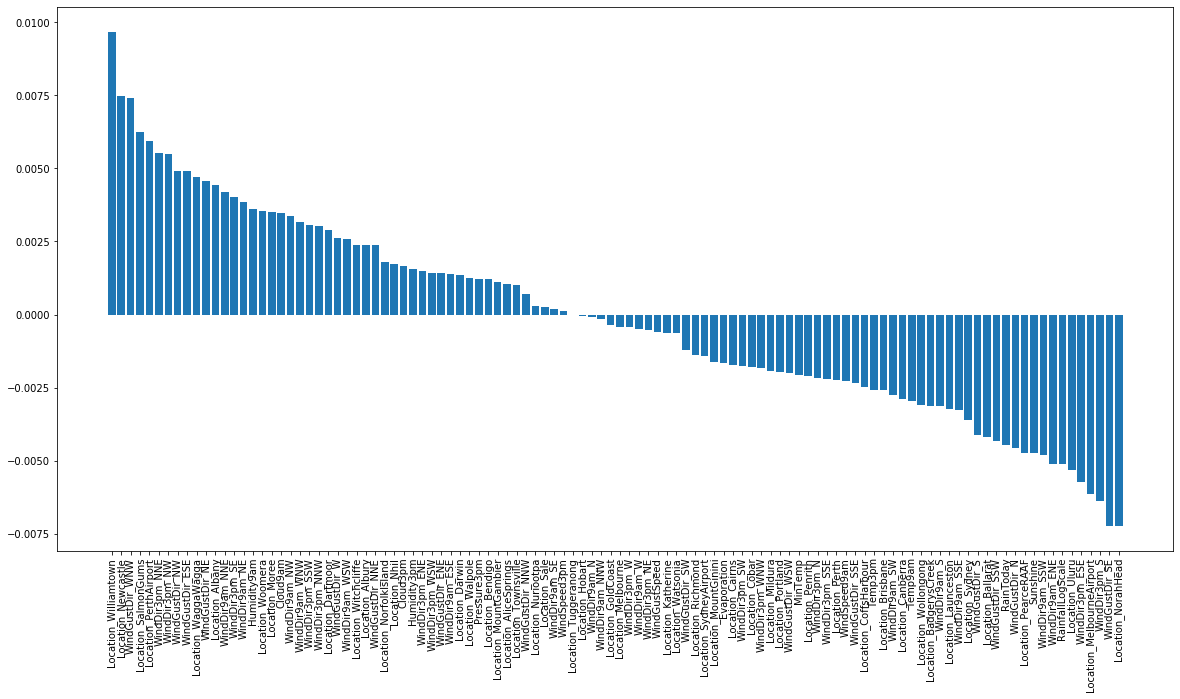

In [203]:
correlations=pd.concat([X_train_new,y_train],axis=1).corr()[['RainTomorrow']].drop('RainTomorrow',axis=0)
correlations.reset_index(inplace=True)
correlations.sort_values('RainTomorrow',ascending=False,inplace=True)

plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
plt.bar(correlations['index'],correlations['RainTomorrow'],width=0.8)

# Train models

First we'll create the function below, which will display back information about the model performances

In [204]:
def modelresults(model, X_train, y_train, X_test, y_test):

    #Predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    #-----------Accuracy, ROC and Cohen's Kappa-------------------
    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    
    roc_train = roc_auc_score(y_train, y_pred_train) 
    roc_test  = roc_auc_score(y_test, y_pred_test)
    
    coh_kap_train = cohen_kappa_score(y_train, y_pred_train)
    coh_kap_test  = cohen_kappa_score(y_test, y_pred_test)
    
    resultdf = pd.DataFrame({"Metric": ['Accuracy', 'ROC', 'Cohen kappa'],"Train" : [accuracy_train ,roc_train, coh_kap_train],"Test" : [accuracy_test, roc_test, coh_kap_test]})

    
    #-----------Confusion matrices-------------------
    cm_train = confusion_matrix(y_train, y_pred_train , labels=[0, 1])
    cm_test  = confusion_matrix(y_test,  y_pred_test ,  labels=[0, 1])

    #-----------ROC Curve---------------------------
    
    probs_train = model.predict_proba(X_train)[:, 1]  
    fptrain, tptrain, thresholds = roc_curve(y_train, probs_train) 
    
    probs_test = model.predict_proba(X_test)[:, 1]  
    fptest, tptest, thresholds = roc_curve(y_test, probs_test) 
    
    
    #-----------Display results-------------------
    
    display(resultdf)
        
    plt.figure(figsize=(20,5))

    plt.subplot(121)
    sns.heatmap(cm_train, annot=True,fmt='g',cmap=plt.cm.Blues)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Training set')

    plt.subplot(122)
    sns.heatmap(cm_test, annot=True,fmt='g',cmap=plt.cm.Blues)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test set')
    
    plt.figure(figsize=(20,7))
    plt.plot(fptrain, tptrain, color='orange', label='ROC- Train Set')
    plt.plot(fptest, tptest, color='red', label='ROC- Test Set')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

### Logistic Regression

In [210]:
from sklearn.linear_model import LogisticRegression

params_lr = {'penalty': 'l1', 'solver':'liblinear'}

model_lr = LogisticRegression(**params_lr)
model_lr.fit(X_train_new,y_train)

LogisticRegression(penalty='l1', solver='liblinear')

Metric     Train      Test
0     Accuracy  0.850062  0.846747
1          ROC  0.732228  0.730131
2  Cohen kappa  0.517516  0.514279

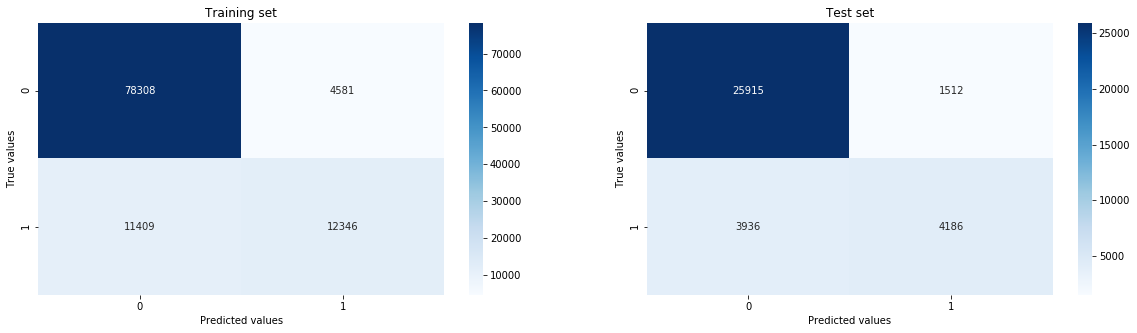

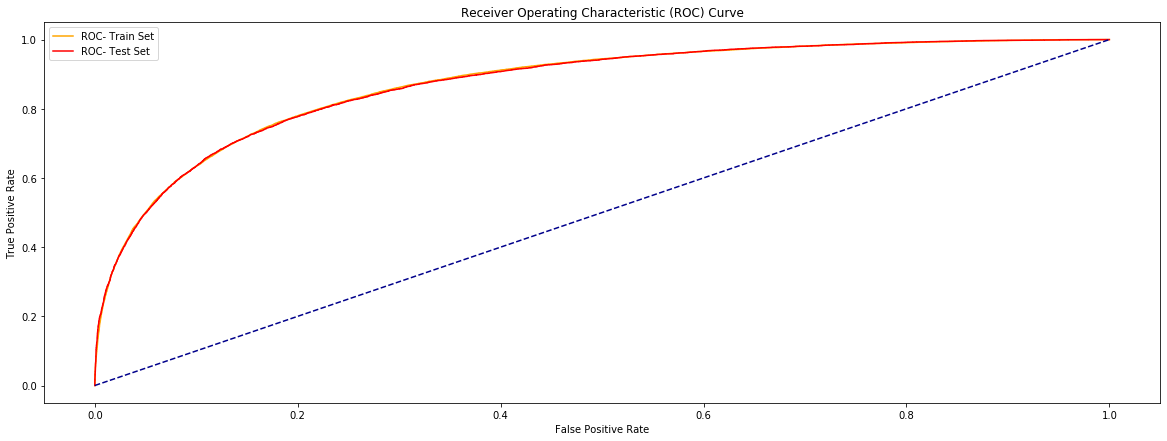

In [211]:
modelresults(model_lr, X_train_new, y_train, X_test_new, y_test)

<BarContainer object of 108 artists>

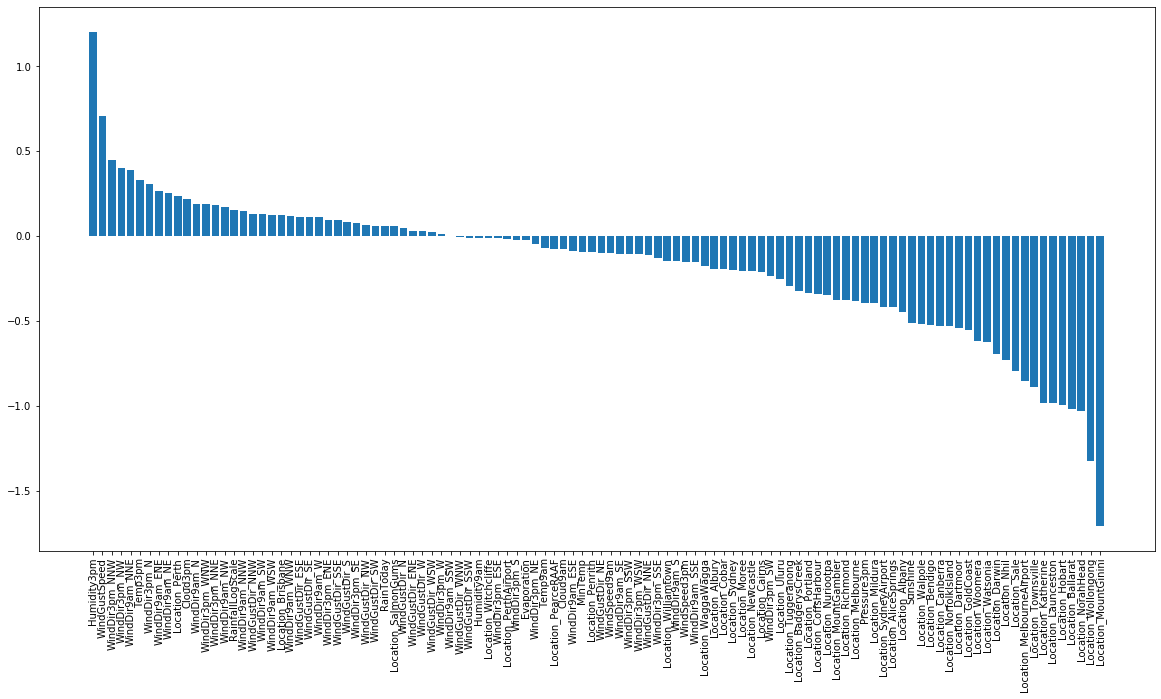

In [212]:

coefficients=pd.DataFrame({"Column" : X_train_new.columns.tolist(),"Coefficient":model_lr.coef_[0].tolist()})
coefficients.sort_values('Coefficient',ascending=False,inplace=True)

plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
plt.bar(coefficients['Column'],coefficients['Coefficient'],width=0.8)

In [213]:
coefficients['CoeffAbs']=coefficients['Coefficient'].abs()
coefficients.sort_values('CoeffAbs',ascending=False,inplace=True)

In [214]:
display(coefficients)

Column  Coefficient  CoeffAbs
37   Location_MountGinini    -1.706208  1.706208
61    Location_Wollongong    -1.325290  1.325290
7             Humidity3pm     1.203977  1.203977
40     Location_NorahHead    -1.030097  1.030097
19      Location_Ballarat    -1.017313  1.017313
..                    ...          ...       ...
105          WindDir3pm_W     0.012993  0.012993
6             Humidity9am    -0.011409  0.011409
73        WindGustDir_SSW    -0.008904  0.008904
76        WindGustDir_WNW    -0.004930  0.004930
88         WindDir9am_SSW     0.000000  0.000000

[108 rows x 3 columns]

The most important predictors in the model consist of Humidity3pm,WindGustSpeed,Temp3pm and several of the location and wind direction label flags.

#### Can we reduce the bias of the logistic regression model with second order polynomial features?

For the numeric features, we'll introduce second order polynomial features & interaction features to see if this allows the model to fit better.

E.g. for features x1 and x2, we'll also have x1^2,x2^2 and x1x2.

In [215]:
from sklearn.preprocessing import PolynomialFeatures

def PolynomialFeatures_labeled(input_df,power):

    poly = PolynomialFeatures(power)
    output_nparray = poly.fit_transform(input_df)
    powers_nparray = poly.powers_

    input_feature_names = list(input_df.columns)
    target_feature_names = ["Constant Term"]
    for feature_distillation in powers_nparray[1:]:
        intermediary_label = ""
        final_label = ""
        for i in range(len(input_feature_names)):
            if feature_distillation[i] == 0:
                continue
            else:
                variable = input_feature_names[i]
                power = feature_distillation[i]
                intermediary_label = "%s^%d" % (variable,power)
                if final_label == "":         #If the final label isn't yet specified
                    final_label = intermediary_label
                else:
                    final_label = final_label + " x " + intermediary_label
        target_feature_names.append(final_label)
    output_df = pd.DataFrame(output_nparray, columns = target_feature_names)
    return output_df


In [221]:
numeric = [var for var in X_train.columns if X_train[var].dtype!='O']

X_train_numpoly = PolynomialFeatures_labeled(X_train_new[numeric],2)
X_test_numpoly = PolynomialFeatures_labeled(X_test_new[numeric],2)

X_train_poly=pd.concat([X_train_numpoly,X_train_new.drop(numeric,axis=1)],axis=1)
X_test_poly=pd.concat([X_test_numpoly,X_test_new.drop(numeric,axis=1)],axis=1)

X_train_poly.head()

Constant Term  MinTemp^1  Evaporation^1  Sunshine^1  WindGustSpeed^1  \
0            1.0   0.642721      -0.507996    0.945301        -0.351467   
1            1.0  -1.500395      -0.290764    0.568469        -0.499459   
2            1.0  -0.546161      -1.214002   -0.069247         0.610483   
3            1.0   0.189069       0.560674    0.928056         0.092510   
4            1.0   0.392430      -0.779537    1.032263        -0.650782   

   WindSpeed9am^1  WindSpeed3pm^1  Humidity9am^1  Humidity3pm^1  \
0        0.562997        0.841652      -0.415855      -0.460781   
1        0.111546        0.042163       0.004689      -0.219244   
2        0.675859        1.070077       1.108617       1.374895   
3       -0.565629       -0.643113      -0.468423      -0.750624   
4       -0.904217       -0.414687       0.057257       0.891822   

   Pressure3pm^1  ...  WindDir3pm_NNW  WindDir3pm_NW  WindDir3pm_S  \
0      -0.235518  ...               0              0             0   
1       0.923360  ...               0              0             1   
2      -1.101010  ...               0              0             1   
3      -0.734276  ...               0              1             0   
4      -0.646260  ...               0              0             0   

   WindDir3pm_SE  WindDir3pm_SSE  WindDir3pm_SSW  WindDir3pm_SW  WindDir3pm_W  \
0              1               0               0              0             0   
1              0               0               0              0             0   
2              0               0               0              0             0   
3              0               0               0              0             0   
4              0               0               0              0             0   

   WindDir3pm_WNW  WindDir3pm_WSW  
0               0               0  
1               0               0  
2               0               0  
3               0               0  
4               0               1  

[5 rows x 229 columns]

In [218]:
params_lr = {'penalty': 'l1', 'solver':'liblinear'}

model_lr_poly = LogisticRegression(**params_lr)
model_lr_poly.fit(X_train_poly,y_train)

LogisticRegression(penalty='l1', solver='liblinear')

Metric     Train      Test
0     Accuracy  0.855294  0.851585
1          ROC  0.743132  0.740676
2  Cohen kappa  0.537802  0.533454

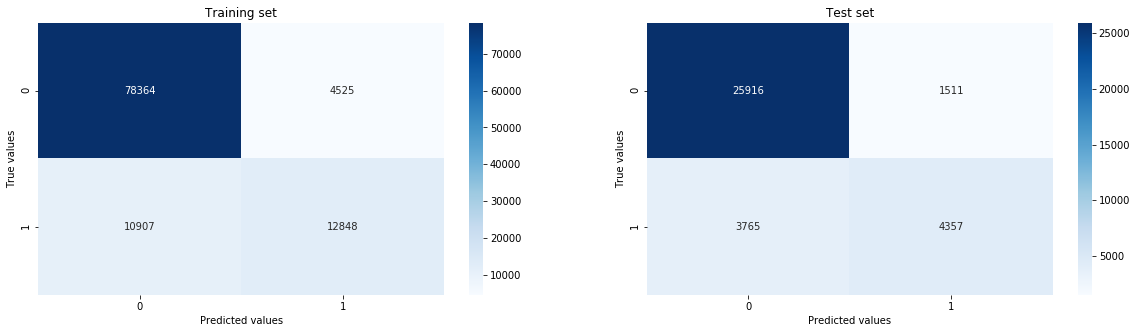

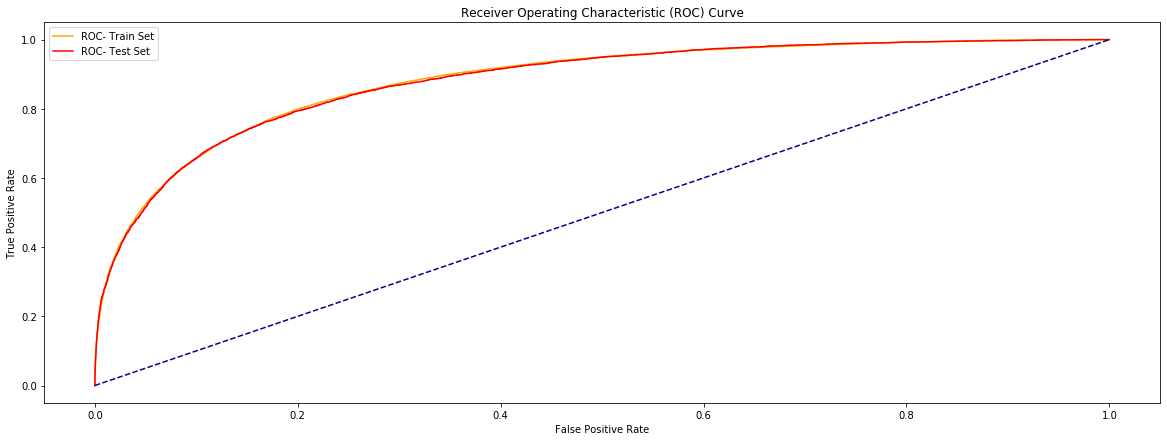

In [219]:
modelresults(model_lr_poly, X_train_poly, y_train, X_test_poly, y_test)

The model accuracy increases only marginally - we could try higher order polynomials but this will introduce hundreds more variables into the model and the improvement in performance is unlikely to be significant.

Of the top 20 features with the highest absolute coefficient values, only 1 is a polynomial feature (RainToday^2).

In [128]:

coefficients=pd.DataFrame({"Column" : X_train_poly.columns.tolist(),"Coefficient":model_lr_poly.coef_[0].tolist()})
coefficients['CoeffAbs']=coefficients['Coefficient'].abs()
coefficients.sort_values('CoeffAbs',ascending=False,inplace=True)

coefficients.head(20)


Column  Coefficient  CoeffAbs
11            Pressure3pm^1    -1.951753  1.951753
199     Location_Wollongong    -1.669598  1.669598
175    Location_MountGinini    -1.619190  1.619190
10            Pressure9am^1     1.554089  1.554089
178      Location_NorahHead    -1.417414  1.417414
15              RainToday^1     1.326851  1.326851
9             Humidity3pm^1     1.116023  1.116023
168      Location_Katherine    -1.102752  1.102752
150             RainToday^2    -1.000566  1.000566
167         Location_Hobart    -0.911226  0.911226
191     Location_Townsville    -0.897849  0.897849
166      Location_GoldCoast    -0.896610  0.896610
169     Location_Launceston    -0.853777  0.853777
179  Location_NorfolkIsland    -0.833814  0.833814
5           WindGustSpeed^1     0.820921  0.820921
187           Location_Sale    -0.764018  0.764018
157       Location_Ballarat    -0.729552  0.729552
200        Location_Woomera    -0.694624  0.694624
186       Location_Richmond    -0.684146  0.684146
190  Location_SydneyAirport    -0.659194  0.659194

### Random Forest Classifier

In [224]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier()
model_rf.fit(X_train_new,y_train)

RandomForestClassifier()

Metric     Train      Test
0     Accuracy  0.999916  0.853160
1          ROC  0.999856  0.728091
2  Cohen kappa  0.999756  0.522729

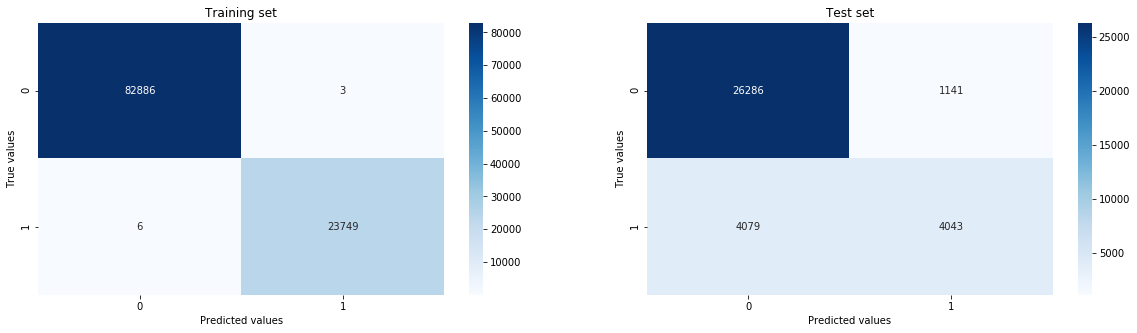

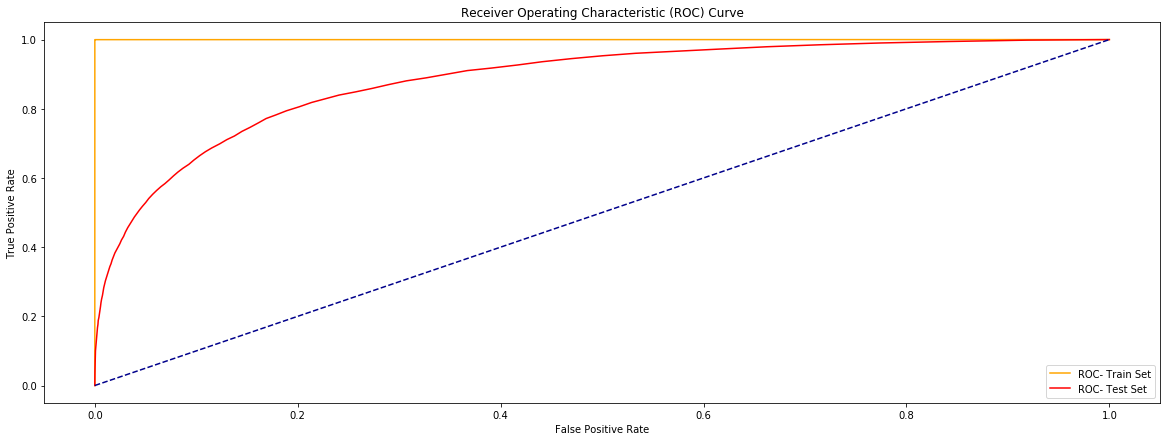

In [225]:
modelresults(model_rf, X_train_new, y_train, X_test_new, y_test)

The random forest model appears to have a slightly better performance on the test data than the logistic regression model.

#### Random forest feature importance

<BarContainer object of 109 artists>

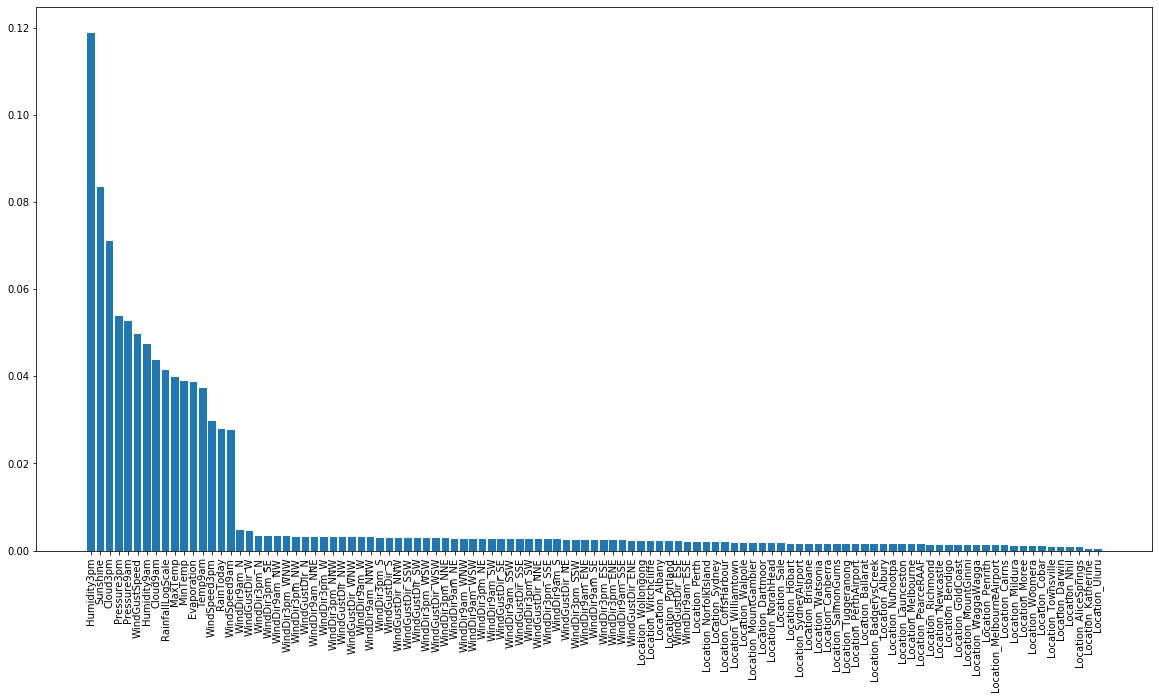

In [116]:
featureimportance = pd.DataFrame({"Column" : X_train_new.columns.tolist(),"FeatureImportance" : model_rf.feature_importances_})
featureimportance.sort_values('FeatureImportance',ascending=False,inplace=True) 

plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
plt.bar(featureimportance['Column'],featureimportance['FeatureImportance'],width=0.8)

What the model seems to have done here is pick out the non-dummy variables as having the highest importance.

It's important to note that this is partly a feature of how random forests work- if there is less variance in the feature (i.e. a binary flag) there is a limitation to how often it can be split in a decision tree. So feature importance is biased towards features that have higher variance.

### XGBoost Classifier

First redefine the model results function as we'll use XGBoost slightly differently

In [142]:
def modelresultsxgb(y_train,preds_train,y_pred_train,y_test,preds_test,y_pred_test):
    
    #-----------Accuracy, ROC and Cohen's Kappa-------------------
    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_test = accuracy_score(y_test, y_pred_test)

    roc_train = roc_auc_score(y_train, y_pred_train) 
    roc_test  = roc_auc_score(y_test, y_pred_test)

    coh_kap_train = cohen_kappa_score(y_train, y_pred_train)
    coh_kap_test  = cohen_kappa_score(y_test, y_pred_test)

    resultdf = pd.DataFrame({"Metric": ['Accuracy', 'ROC', 'Cohen kappa'],"Train" : [accuracy_train ,roc_train, coh_kap_train],"Test" : [accuracy_test, roc_test, coh_kap_test]})


    #-----------Confusion matrices-------------------
    cm_train = confusion_matrix(y_train, y_pred_train , labels=[0, 1])
    cm_test  = confusion_matrix(y_test,  y_pred_test ,  labels=[0, 1])

    #-----------ROC Curve---------------------------

    probs_train = preds_train[:,1]  
    fptrain, tptrain, thresholds = roc_curve(y_train, probs_train) 

    probs_test = preds_test[:,1] 
    fptest, tptest, thresholds = roc_curve(y_test, probs_test) 


    #-----------Display results-------------------

    display(resultdf)

    plt.figure(figsize=(20,5))

    plt.subplot(121)
    sns.heatmap(cm_train, annot=True,fmt='g',cmap=plt.cm.Blues)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Training set')

    plt.subplot(122)
    sns.heatmap(cm_test, annot=True,fmt='g',cmap=plt.cm.Blues)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test set')

    plt.figure(figsize=(20,7))
    plt.plot(fptrain, tptrain, color='orange', label='ROC- Train Set')
    plt.plot(fptest, tptest, color='red', label='ROC- Test Set')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [119]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train_new, label=y_train)
dtest = xgb.DMatrix(X_test_new, label=y_test)

In [145]:
param = {
    'max_depth': 10,  # Maximum depth of each tree
    'eta': 0.1,  # Learning rate - the training step size for each iteration
    'silent': 1,  
    'objective': 'multi:softprob',  
    'num_class': 2}  

model_xgb = xgb.train(param, dtrain, 400)

In [146]:
preds_train=model_xgb.predict(dtrain)
preds_test=model_xgb.predict(dtest)

y_pred_train = np.asarray([np.argmax(line) for line in preds_train])
y_pred_test = np.asarray([np.argmax(line) for line in preds_test])

Metric     Train      Test
0     Accuracy  0.979192  0.861965
1          ROC  0.956147  0.759406
2  Cohen kappa  0.938202  0.569905

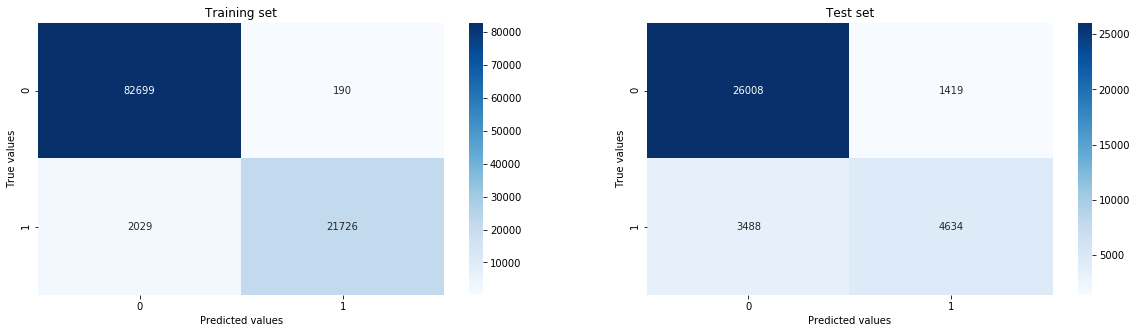

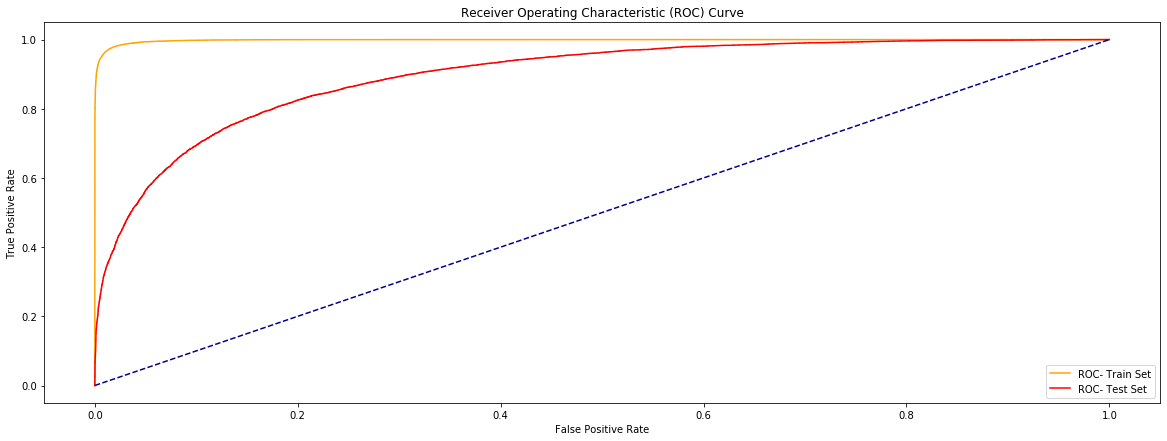

In [147]:
modelresultsxgb(y_train,preds_train,y_pred_train,y_test,preds_test,y_pred_test)

XGBoost performed slightly better on the test set than either logistic regression or random forest, so we'll attempt to optimise further by tuning the parameters.

### Randomized search cross validation

In [135]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'max_depth': range(5, 15),
    'n_estimators':range(100, 1000),
    'eta': [0.01, 0.1, 0.2, 0.3]
}

model_xgb_rand = xgb.XGBClassifier()
randomized_xgb = RandomizedSearchCV(estimator=model_xgb_rand,param_distributions=param_grid,scoring = 'accuracy',n_iter = 15, cv = 2,n_jobs=-1)
randomized_xgb.fit(X_train_new,y_train)

RandomizedSearchCV(cv=2, estimator=XGBClassifier(), n_jobs=-1,
                   param_distributions={'eta': [0.01, 0.1, 0.2, 0, 3],
                                        'max_depth': range(5, 15),
                                        'n_estimators': range(100, 1000)},
                   scoring='accuracy')

In [174]:
print("Best parameters: ", randomized_xgb.best_params_)
print("Best Score: ", randomized_xgb.best_score_)

Best parameters:  {'n_estimators': 742, 'max_depth': 7, 'eta': 0.1}
Best Score:  0.9126451745996024


In [ ]:
param = {
    'max_depth': 7, 
    'eta': 0.1,  
    'silent': 1,  
    'objective': 'multi:softprob',  
    'num_class': 2}  

xgb_best = xgb.train(param, dtrain, 742)

In [ ]:
preds_train=xgb_best.predict(dtrain)
preds_test=xgb_best.predict(dtest)

y_pred_train = np.asarray([np.argmax(line) for line in preds_train])
y_pred_test = np.asarray([np.argmax(line) for line in preds_test])

Metric     Train      Test
0     Accuracy  0.979192  0.914287
1          ROC  0.956147  0.840978
2  Cohen kappa  0.938202  0.737186

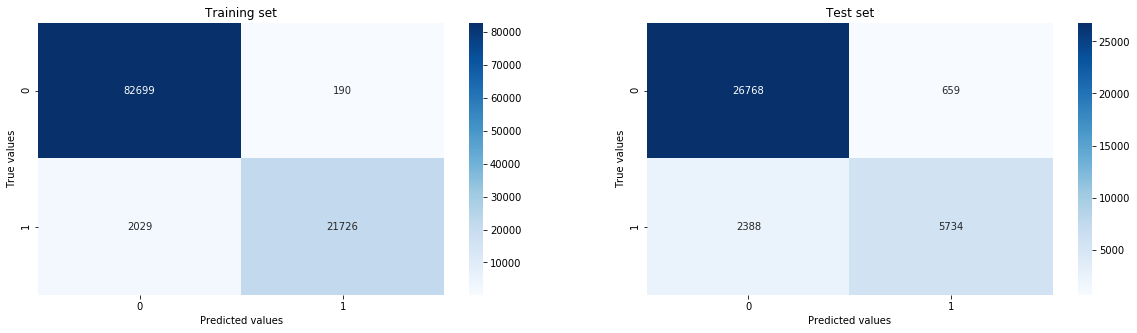

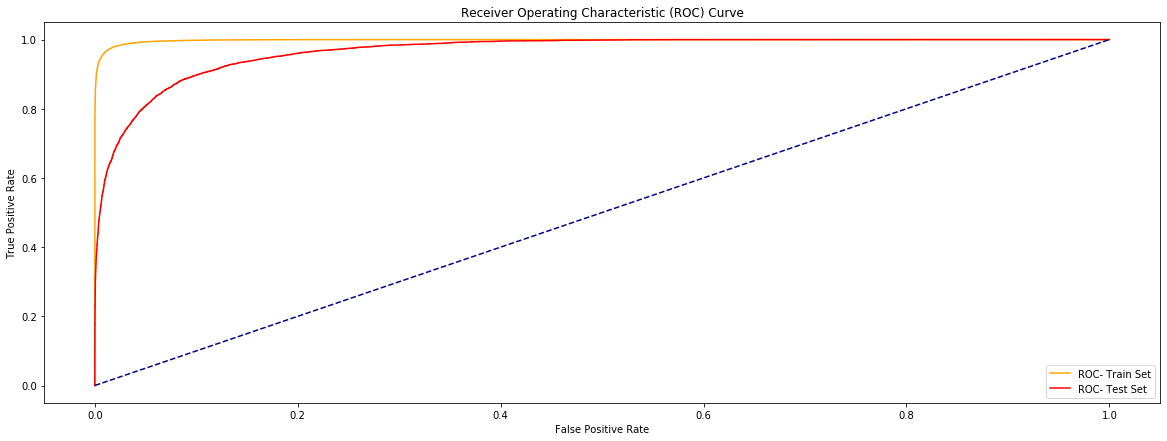

In [173]:
modelresultsxgb(y_train,preds_train,y_pred_train,y_test,preds_test,y_pred_test)

By tuning the hyper-parameters, the performance of the model has improved significantly!